In [ ]:
!pip install vaderSentiment -q
!pip install strsim -q
!pip install textblob -q

In [ ]:
import string
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from similarity.normalized_levenshtein import NormalizedLevenshtein
from similarity.jarowinkler import JaroWinkler
from similarity.longest_common_subsequence import LongestCommonSubsequence

In [ ]:
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target) ** 2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f"| MSE: {mse:.4f} | RMSE: {rmse:.4f} |")
    return sse, mse


In [ ]:
nltk.download("averaged_perceptron_tagger")
nltk.download('wordnet')

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_columns", 500)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_h = pd.read_csv("data/train.csv")
train_f = pd.read_csv("data/train_funlines.csv")

dev_h = pd.read_csv("data/dev.csv")
test_h = pd.read_csv("data/test_with_label.csv")

In [ ]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduces memory requirements for pandas dataframe
    :param df: DataFrame
    :verbose: bool
    """
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


def apply(list_of_dfs, fn):
    """
    Applies a function to a list of pandas dataframes
    :param list_of_dfs: list of pandas DataFrames
    :param fn: function to be applied
    """
    for i in list_of_dfs:
        i = fn(i)


X = [train_h, train_f, dev_h, test_h]

apply(X, reduce_mem_usage)

Mem. usage decreased to  0.26 Mb (30.0% reduction)
Mem. usage decreased to  0.24 Mb (25.0% reduction)
Mem. usage decreased to  0.06 Mb (30.0% reduction)
Mem. usage decreased to  0.08 Mb (30.0% reduction)


In [ ]:

nans = lambda df: print(df[df.isnull().any(axis=1)])
apply(X, nans)


Empty DataFrame
Columns: [id, original, edit, grades, meanGrade]
Index: []
Empty DataFrame
Columns: [id, original, edit, grades, meanGrade]
Index: []
Empty DataFrame
Columns: [id, original, edit, grades, meanGrade]
Index: []
Empty DataFrame
Columns: [id, original, edit, grades, meanGrade]
Index: []


In [ ]:
def get_position_and_context(df, column="original"):
    """
    Extract the word to be replaced from the original column, and the surrounding context as additional column(s)
    :param df: pandas DataFrame
    """

    df["old_word"] = df[column].apply(lambda x: re.findall("<(.*)/>", x)[0])
    df["context"] = df[column].apply(lambda x: re.findall("(.*)<.*/>(.*)", x)[0])
    df["context"] = df["context"].apply(lambda x: [j.strip() for j in x])
    return df

def get_sentences(df):
    """
    Extract the edited sentence and the original non-edited sentence as additional column(s)
    :param df: pandas DataFrame
    """

    def get_edited_and_non(df):
        edited = df.context[0] + " " + df.edit + " " + df.context[1]
        non_edited = df.context[0] + " " + df.old_word + " " + df.context[1]
        return edited, non_edited

    df["edited"], df["non_edited"] = zip(*df.apply(get_edited_and_non, axis=1))


apply(X, get_position_and_context)
apply(X, get_sentences)
print(len(train_h.columns))  # 9

9


In [ ]:
def string_similarity_metrics(df):
    """
    Extract string similarity metrics between the edited and original word as additional column(s)
    :param df: pandas DataFrame
    """

    df["Levenshtein"] = [NormalizedLevenshtein().distance(i, j) for i, j in zip(df["edit"], df["old_word"])]
    df["JaroWinkler"] = [JaroWinkler().distance(i, j) for i, j in zip(df["edit"], df["old_word"])]
    df["LCSubsequence"] = [
        LongestCommonSubsequence().distance(i, j) for i, j in zip(df["edit"], df["old_word"])
    ]


apply(X, string_similarity_metrics)  # 12
print(len(train_h.columns))

12


In [ ]:
def other_hand_craft(df, column="non_edited"):
    """
    Extract a number of lexical hand-crafted features for experimentation as additional column(s)
    :param df: pandas DataFrame
    :param column: str
    """

    df["length"] = df[column].apply(lambda x: len(x))
    df["capitals"] = df[column].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df["caps_vs_length"] = df.apply(lambda row: float(row["capitals"]) / float(row["length"]), axis=1)
    df["num_exclamation_marks"] = df[column].apply(lambda comment: comment.count("!"))
    df["num_question_marks"] = df[column].apply(lambda comment: comment.count("?"))
    df["num_punctuation"] = df[column].apply(lambda comment: sum(comment.count(w) for w in ".,;:"))
    df["num_symbols"] = df[column].apply(lambda comment: sum(comment.count(w) for w in "*&$%"))
    df["num_words"] = df[column].apply(lambda comment: len(comment.split()))
    df["num_unique_words"] = df[column].apply(lambda comment: len(set(w for w in comment.split())))
    df["words_vs_unique"] = df["num_unique_words"] / df["num_words"]
    df["num_smilies"] = df[column].apply(
        lambda comment: sum(comment.count(w) for w in (":-)", ":)", ";-)", ";)", ":-<", ":()", ";-()", ";("))
    )
    df["count_words_title"] = df[column].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df[column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df["punct_percent"] = df["num_punctuation"] * 100 / df["num_words"]


apply(X, other_hand_craft)
print(len(train_h.columns))  # 26

26


In [ ]:
def remove(df, column="non_edited"):
    """
    Pre-processing for the remaining hand-crafted features, non-word symbol removal except apostrophes and hyphens
    :param df: pandas DataFrame
    :param column: str
    """

    def remove_non_word(x):
        X = re.compile("[^A-Za-z--–— ']")  # keep apostrophes and hyphens
        x = X.sub("", x)
        x = re.sub(" +", " ", x)
        return x

    df[column] = df[column].apply(remove_non_word)


apply(X, remove)
apply(X, lambda x: remove(x,'edited'))

In [ ]:
lemm = WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    """
    A class to conduct Lemmatization on top of the CountVectorizer, to prepare for LDA topic modelling
    """
    
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()

        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))



# Storing the entire training text in a list
text = list(train_h.edited.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)
lda = LatentDirichletAllocation(n_components=6, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

lda.fit(tf)


def print_top_words(model, feature_names, n_top_words):
    """
    prints the top words defining each Topic found by LDA

    :param model: sklearn LDA model
    :param feature_names: the feature names from the Vectorizer
    :param n_top_words: number of most defining words of each topic
    """
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))


n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

The lemmatized form of leaves is: leaf

Topics in LDA model: 

Topic #0:trump russia gop say new senate democrat clinton health government election vote care hillary senator official investigation call republican campaign black amid end help nominee probe facebook way special seek just firing world party blame killed session tell washington sander

Topic #1:say china trump american day attack military year right rule deal hit police child talk protester ex state student new party dead sexual school south brexit kill lawmaker uk old sue latest work hope syria eu puppy comment set vow

Topic #2:trump russian mueller say obamacare news twitter report state big medium paul anti fox charlottesville justice book bbc sign cnn charge death fake putin ryan turkey republican robert deal abortion alleged monkey year texas source repeal family left said start

Topic #3:trump donald say new tax house plan president nt republican time gop cut face congress california wall comey political leader obam

In [ ]:
# Mutually exclusive words extracted from each topic
topic0 = ['roy', 'session', 'alabama', 'official', 'special', 'chinese', 'washington', 'security', 'big', 'state', 'did', 'investigation', 'james', 'report', 'comey', 'obamacare', 'national', 'america', 'repeal', 'senator', 'moore', 'firing', 'poll', 'twitter']

topic1 = ['attempt', 'bernie', 'black', 'blame', 'book', 'campaign', 'city', 'clinton', 'day', 'doe', 'election', 'far', 'food', 'gun', 'hillary', 'hit', 'make', 'military', 'obama', 'old', 'party', 'presidential', 'protester', 'rally', 'right', 'sander', 'texas', 'want', 'win', 'world']

topic2 = ['drug', 'help', 'chief', 'vote', 'administration', 'test', 'prime', 'care', 'john', 'israel', 'cnn', 'north', 'face', 'video', 'american', 'threatens', 'minister', 'south', 'turkey', 'missile', 'mccain', 'nuclear', 'health', 'senate', 'leader', 'like', 'korea', 'korean', 'tax', 'call', 'nominee', 'ahead']

topic3 = ['street', 'life', 'sexual', 'charlottesville', 'fox', 'killed', 'sign', 'history', 'case', 'shutdown', 'billion', 'federal', 'wall', 'paul', 'amid', 'manafort', 'uk', 'police', 'way', 'despite', 'end', 'program', 'people', 'leave', 'long', 'judge', 'saudi', 'warns', 'fear', 'attack', 'ryan', 'border', 'let', 'news', 'government']

topic4 = ['wo', 'tweet', 'meet', 'jr', 'fbi', 'talk', 'republican', 'robert', 'democratic', 'school', 'ban', 'lawyer', 'michael', 'foreign', 'white', 'putin', 'court', 'charge', 'house', 'president', 'expert', 'dead', 'need', 'penny', 'going', 'probe', 'just', 'russia', 'rep', 'syria', 'political', 'mueller']

topic5 = ['jones', 'rico', 'open', 'puerto', '10', 'kushner', 'healthcare', 'really', '000', 'shut', 'massive', 'saying', 'harvey', 'trade', 'funding', 'jared', 'disaster', 'porn', 'offer', 'kill', 'penguin', 'comment', 'restaurant', 'lead', 'banana', 'mexico', 'million', 'pay', 'anti', 'general', 'attorney', 'gov', 'china']


In [ ]:
def contains_word_in_set(x, word_set):
    """
    set of words to see if x contains any of them
    :param x: str
    :param word_set: set of words to see if x contains any of them
    :return: bool
    """
    if any(elem in x for elem in word_set):
        return 1
    return 0


def apply_topics(df):
    """
    Extract a number of Topic features for experimentation as additional column(s)
    :param df: pandas DataFrame
    """
    df["topic_0"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic0))

    df["topic_1"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic1))

    df["topic_2"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic2))
    df["topic_3"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic3))
    df["topic_4"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic4))
    df["topic_5"] = df["edited"].apply(lambda x: contains_word_in_set(x, topic5))


def apply_trump(df):
    """
    Extract a feature to mark the mention of Trump in the edited sentence
    :param df: pandas DataFrame
    """
    df["trump"] = df["edited"].apply(
        lambda x: contains_word_in_set(x, word_set=["trump", "Trump", "Donald", "donald", ":trump"])
    )

In [ ]:
apply(X, apply_trump)
apply(X, apply_topics)
print(len(train_h.columns))  # 33


33


In [ ]:
def tag_part_of_speech(df):
    """
    Extract POS features of the originl sentence and also a POS feature specific to the original word
    :param df: pandas DataFrame
    """
    text = df.non_edited
    old_word = df.old_word
    text_splited = text.split(" ")
    text_splited = ["".join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    for i in pos_list:
        old_word_type = "O"
        if i[0] == old_word:
            if i[1] in ("NN", "NNP", "NNPS", "NNS"):
                old_word_type = "N"
            elif i[1] in ("JJ", "JJR", "JJS"):
                old_word_type = "J"
            elif i[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
                old_word_type = "V"

    noun_count = len([w for w in pos_list if w[1] in ("NN", "NNP", "NNPS", "NNS")])
    adjective_count = len([w for w in pos_list if w[1] in ("JJ", "JJR", "JJS")])
    verb_count = len([w for w in pos_list if w[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ")])
    return [noun_count, adjective_count, verb_count, old_word_type]


def get_edit_word_pos(df):
    """
    Extract POS features specific to the edit word
    :param df: pandas DataFrame
    """
    text = df.non_edited
    old_word = df.old_word
    edit = df.edit
    text = text.replace(old_word, edit)
    text_splited = text.split(" ")
    text_splited = ["".join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    for i in pos_list:
        edit_word_type = "O"
        if i[0] == edit:
            if i[1] in ("NN", "NNP", "NNPS", "NNS"):
                edit_word_type = "N"
            elif i[1] in ("JJ", "JJR", "JJS"):
                edit_word_type = "J"
            elif i[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
                edit_word_type = "V"
    return edit_word_type


def pos_features(df):
    """
    Extract further POS features
    :param df: pandas DataFrame
    """

    df["nouns"], df["adjectives"], df["verbs"], df["old_word_pos"] = zip(*df.apply(tag_part_of_speech, axis=1))
    df["edit_word_pos"] = df.apply(get_edit_word_pos, axis=1)

    df["nouns_vs_length"] = df["nouns"] / df["length"]
    df["adjectives_vs_length"] = df["adjectives"] / df["length"]
    df["verbs_vs_length"] = df["verbs"] / df["length"]
    df["nouns_vs_words"] = df["nouns"] / df["num_words"]
    df["adjectives_vs_words"] = df["adjectives"] / df["num_words"]
    df["verbs_vs_words"] = df["verbs"] / df["num_words"]


apply(X, pos_features)
print(len(train_h.columns))  # 44


44


In [ ]:
def dummy_columns(df):
    """
    Make Dummy Columns from the edit word POS tag and original word POS tag
    :param df: pandas DataFrame
    """
    edit = df[["edit_word_pos"]]
    dummy_cols_for_edit = pd.get_dummies(edit)
    dummy_cols_for_edit.drop(columns="edit_word_pos_O", axis=1, inplace=True)
    df = pd.concat([df, dummy_cols_for_edit], axis=1)

    edit = df[["old_word_pos"]]
    dummy_cols_for_edit = pd.get_dummies(edit)
    dummy_cols_for_edit.drop(columns="old_word_pos_O", axis=1, inplace=True)
    df = pd.concat([df, dummy_cols_for_edit], axis=1)
    return df


train_h = dummy_columns(train_h)
train_f = dummy_columns(train_f)
dev_h = dummy_columns(dev_h)
test_h = dummy_columns(test_h)
X = [train_h, train_f, dev_h, test_h]
len(train_h.columns)  # 50

50

In [ ]:
def word_count_features(df, column="non_edited"):
    """
    Extract more lexical type features as additional column(s)
    :param df: pandas DataFrame
    :param column: str
    """

    df["word_count"] = [len(str(x).split(" ")) for x in df[column]]
    df["position"] = df["context"].apply(lambda x: len(str(x[0]).split(" ")) + 1)
    df["relative_position"] = df["position"] / df["word_count"]


def character_count(x):
    """
    Extract the character count from a string, excluding some symbols
    :param x: str
    """
    chars = "".join(x.split())
    nonchars = [".", "!", "?", ",", ":", ";", "-", "'"]
    return len([char for char in chars if char not in nonchars])


def sentiment_features(df, column="non_edited"):
    """
    Extract textblob, vader sentiment and subjectivity faetures, as wwell as relative sentiment as additional columns
    :param df: pandas DataFrame
    :param column: str
    """

    def capital_letter_count(x):
        return sum(1 for c in x if c.isupper())

    analyser = SentimentIntensityAnalyzer()
    df["vader_sentiment"] = [analyser.polarity_scores(i)["compound"] for i in df[column]]

    df["relative_sentiment"] = [
        analyser.polarity_scores(i[0])["compound"] - (analyser.polarity_scores(i[1])["compound"]) for i in df["context"]
    ]
    character_c = df["original"].apply(character_count)
    df["av_word_length"] = df["word_count"] / character_c
    capital_letter = train_h["original"].apply(capital_letter_count)
    df["capital_letter_per_word"] = capital_letter / df["word_count"]
    df["relative_sentiment2"] = (
        analyser.polarity_scores(df["edit"])["compound"] - analyser.polarity_scores(df["old_word"])["compound"]
    )

    df["textblob_polarity"] = [TextBlob(i).polarity for i in df["edited"]]
    df["textblob_subjectivity"] = [TextBlob(i).polarity for i in df["edited"]]


apply(X, word_count_features)
apply(X, sentiment_features)
print(len(train_h.columns)) 

60


In [ ]:
def tf_idf(train_df=train_h, test_df=dev_h):
    """
    Build a TF-IDF Transformer, built on the LemmaCountVectorizer class, fit-transform on train_df, and transformed on test_df.
    The features from this TF-IDF transfomer are used to build a Ridge Linear Regression Model, with the optimal
    parameters from Grid Search.
    Extract the predictions as additional columns
    :param train_df: pandas DataFrame
    :param test_df: str
    """
    lemm = WordNetLemmatizer()

    training_data = train_df["original"]
    test_data = test_df["original"]
    training_y = train_df["meanGrade"]

    # We train a Tf-idf model
    count_vect = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words="english", decode_error="ignore")

    train_counts = count_vect.fit_transform(training_data)
    transformer = TfidfTransformer().fit(train_counts)
    train_counts = transformer.transform(train_counts)
    regression_model = linear_model.Ridge(alpha=15).fit(train_counts, training_y)

    test_counts = count_vect.transform(test_data)

    test_counts = transformer.transform(test_counts)

    # Train predictions
    predicted_train = regression_model.predict(train_counts)

    predicted = regression_model.predict(test_counts)

    train_df["tf_idf_predictions"] = predicted_train
    test_df["tf_idf_predictions"] = predicted

tf_idf(train_h, dev_h)
print(len(train_h.columns))  # 61

print(train_h.columns) # Features to choose from for hand-crafted final model

61
Index(['id', 'original', 'edit', 'grades', 'meanGrade', 'old_word', 'context',
       'edited', 'non_edited', 'Levenshtein', 'JaroWinkler', 'LCSubsequence',
       'length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'words_vs_unique', 'num_smilies',
       'count_words_title', 'mean_word_len', 'punct_percent', 'trump',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'nouns', 'adjectives', 'verbs', 'old_word_pos', 'edit_word_pos',
       'nouns_vs_length', 'adjectives_vs_length', 'verbs_vs_length',
       'nouns_vs_words', 'adjectives_vs_words', 'verbs_vs_words',
       'edit_word_pos_J', 'edit_word_pos_N', 'edit_word_pos_V',
       'old_word_pos_J', 'old_word_pos_N', 'old_word_pos_V', 'word_count',
       'position', 'relative_position', 'vader_sentiment',
       'relative_sentiment', 'av_word_length', 'capital_letter_per_word',
       '

In [ ]:
print('TF_IDF train Linear Regression with Tikinhov Regularization')
print(model_performance(train_h["tf_idf_predictions"],train_h['meanGrade'],True))
print('\n')
print('TF_IDF_only dev',model_performance(dev_h["tf_idf_predictions"],dev_h['meanGrade'],True))


TF_IDF train Linear Regression with Tikinhov Regularization
| MSE: 0.2944 | RMSE: 0.5426 |
(2841.853525989582, 0.2944315712794855)


| MSE: 0.3293 | RMSE: 0.5739 |
TF_IDF_only dev (796.6159700155702, 0.32931623398742027)


In [ ]:
# final chosen features for gradient boosting
features = ['Levenshtein', 'JaroWinkler',
       'LCSubsequence', 'length', 'capitals', 'caps_vs_length',
       'num_exclamation_marks', 'num_question_marks', 'num_punctuation',
       'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique',
       'num_smilies', 'count_words_title', 'mean_word_len', 'punct_percent',
       'nouns', 'adjectives', 'verbs', 
       'nouns_vs_length', 'adjectives_vs_length', 'verbs_vs_length',
       'nouns_vs_words', 'adjectives_vs_words', 'verbs_vs_words',
       'edit_word_pos_J', 'edit_word_pos_N', 'edit_word_pos_V',
       'old_word_pos_J', 'old_word_pos_N', 'old_word_pos_V', 'word_count',
       'position', 'relative_position', 'vader_sentiment',
       'relative_sentiment', 'av_word_length', 'capital_letter_per_word',
       'relative_sentiment2', 'textblob_polarity', 'textblob_subjectivity','trump', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
       'topic_5']



In [ ]:
train_X = train_h[features]
train_y = train_h['meanGrade']

dev_X = dev_h[features]
dev_Y = dev_h['meanGrade']
target = train_y
train = train_h
test = dev_h

In [ ]:
# Grid Search different Experiments
# params = {
#     "num_leaves": 31,
#     "min_data_in_leaf": 30,
#     "objective": "regression",
#     "max_depth": -1,
#     "learning_rate": 0.01,
#     "min_child_samples": 20,
#     "boosting": "gbdt",
#     "feature_fraction": 0.9,
#     "bagging_freq": 1,
#     "bagging_fraction": 0.9,
#     "bagging_seed": 11,
#     "metric": "rmse",
#     "lambda_l1": 0.1,
#     "verbosity": -1,
#     "nthread": 4,
#     "random_state": 4590,
# }

# # Create parameters to search
# gridParams = {
#     'learning_rate': [0.01,0.005],
#     'n_estimators': [40],
#     'num_leaves': [6,8,12,16],
#     'boosting_type' : ['gbdt'],
#     'random_state' : [501], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
#     }



# # Create classifier to use. Note that parameters have to be input manually
# # not as a dict!
# mdl = lgb.LGBMRegressor(**params)

# # To view the default model params:
# mdl.get_params().keys()

# # Create the grid
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)
# # # Run the grid
# grid.fit(train[features], target)

# # # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

In [ ]:
# Best Parameters from GridSearch
param = {
    "num_leaves": 31,
    "min_data_in_leaf": 30,
    "objective": "regression",
    "max_depth": -1,
    "learning_rate": 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": "rmse",
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 4590,
}


In [ ]:
def light_gbm(train, target, test, features, param=param):
    """
    Build a Light Gradient Boosting Model (Similar to XGboost), running 5 folds of Cross-validation
    with Early Stopping. Extract the predictions as additional columns
    :param train: pandas DataFrame
    :param test_df: str
    """

    folds = KFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    predictions_train = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(
            train.iloc[trn_idx][features], label=target.iloc[trn_idx]
        )  # , categorical_feature=categorical_feats)
        val_data = lgb.Dataset(
            train.iloc[val_idx][features], label=target.iloc[val_idx]
        )  # ,categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(
            param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100, early_stopping_rounds=200
        )
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["Importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
        predictions_train += clf.predict(train[features], num_iteration=clf.best_iteration) / folds.n_splits

    np.sqrt(MSE(oof, target))

    rmse = np.sqrt(MSE(test["meanGrade"], predictions))
    print("training RMSE", np.sqrt(MSE(train["meanGrade"], predictions_train)))
    print("testing RMSE", rmse)
    return predictions, predictions_train, feature_importance_df


def feature_importance_graph(feature_importance_df):
    """
    Producing a graph from the Cross-validation gradient boosting algorithm,
    showing how often each feature was used in the boosted decision trees,
    with variance bars. There are no absolute units due to the way the algorithm works
    but it gives strong indication of the most useful features for the model, across folds/

    :param feature_importance_df: pandas DataFrame
    :return: matplotlib plot
    """

    cols = (
        feature_importance_df[["Feature", "Importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="Importance", ascending=False)[:1000]
        .index
    )

    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(14, 25))
    ax = sns.barplot(y="Importance", x="Feature", data=best_features.sort_values(by="Importance", ascending=False), )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    l = ax.get_xlabel()
    g = ax.get_ylabel()
    ax.set_xlabel(l, fontsize=20)
    ax.set_ylabel(g, fontsize=20)
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
    return plt


In [ ]:
# Performing Cross Validation on train Humiocrit only, testing on the dev set

predictions, predictions_train, feature_importance_df = light_gbm(train_h, train_h['meanGrade'], dev_h, features)


fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.557528	valid_1's rmse: 0.577452
[200]	training's rmse: 0.541168	valid_1's rmse: 0.576385
[300]	training's rmse: 0.527183	valid_1's rmse: 0.575644
[400]	training's rmse: 0.514972	valid_1's rmse: 0.574666
[500]	training's rmse: 0.503898	valid_1's rmse: 0.574068
[600]	training's rmse: 0.493738	valid_1's rmse: 0.573685
[700]	training's rmse: 0.483992	valid_1's rmse: 0.573254
[800]	training's rmse: 0.474759	valid_1's rmse: 0.573132
[900]	training's rmse: 0.466197	valid_1's rmse: 0.573119
[1000]	training's rmse: 0.457891	valid_1's rmse: 0.573233
[1100]	training's rmse: 0.44991	valid_1's rmse: 0.573748
Early stopping, best iteration is:
[918]	training's rmse: 0.464675	valid_1's rmse: 0.573066
fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.56034	valid_1's rmse: 0.567097
[200]	training's rmse: 0.544424	valid_1's rmse: 0.563384
[300]	training's rmse: 0.53

In [ ]:
print('Gradient Boosting Hand Crafted dev set performance')
print(model_performance(predictions,dev_h['meanGrade'],True))


Gradient Boosting Hand Crafted dev set performance
| MSE: 0.3299 | RMSE: 0.5744 |
(798.1339163405084, 0.3299437438365056)


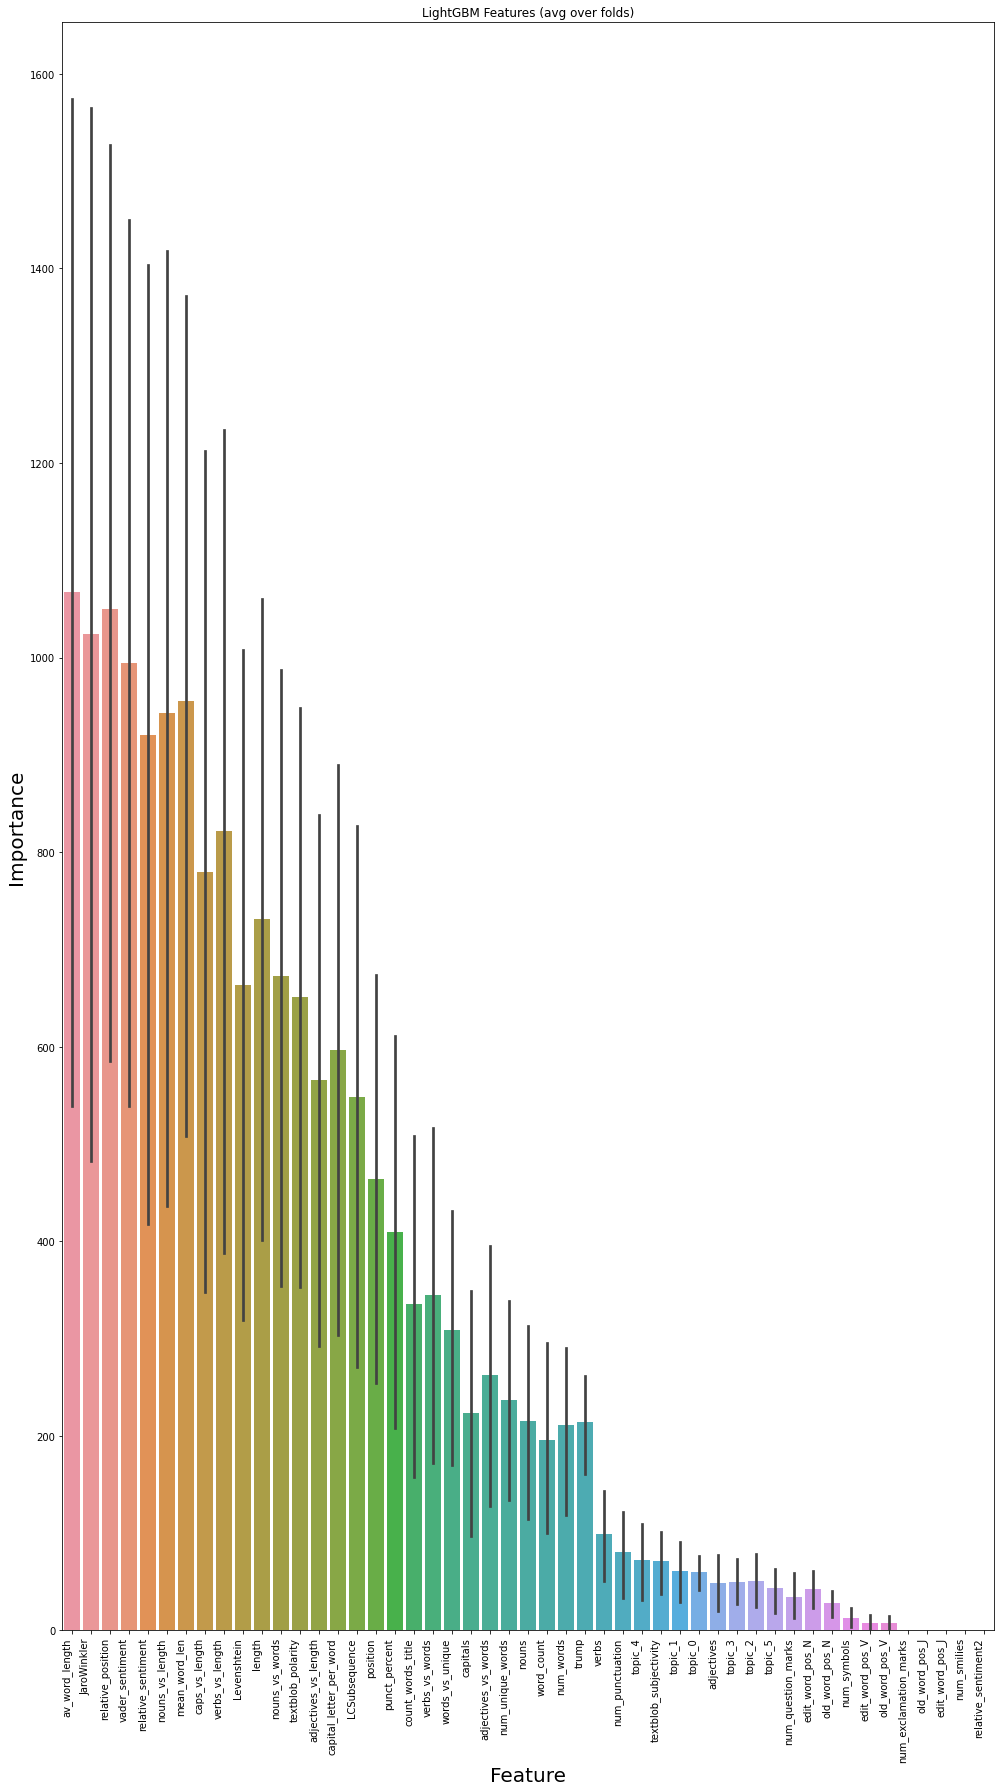

In [ ]:
plt = feature_importance_graph(feature_importance_df)

In [ ]:
cols = (
    feature_importance_df[["Feature", "Importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="Importance", ascending=False)[:1000]
    .index
)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

In [ ]:
remove_for_report = ['topic_1',
       'topic_0', 'topic_2', 'topic_3', 'adjectives', 'topic_5',
       'edit_word_pos_N', 'num_question_marks', 'old_word_pos_N',
       'num_symbols', 'old_word_pos_V', 'edit_word_pos_V',
       'num_exclamation_marks', 'relative_sentiment2', 'num_smilies',
       'old_word_pos_J', 'edit_word_pos_J']

In [ ]:
report = feature_importance_df[~feature_importance_df['Feature'].isin(remove_for_report)]

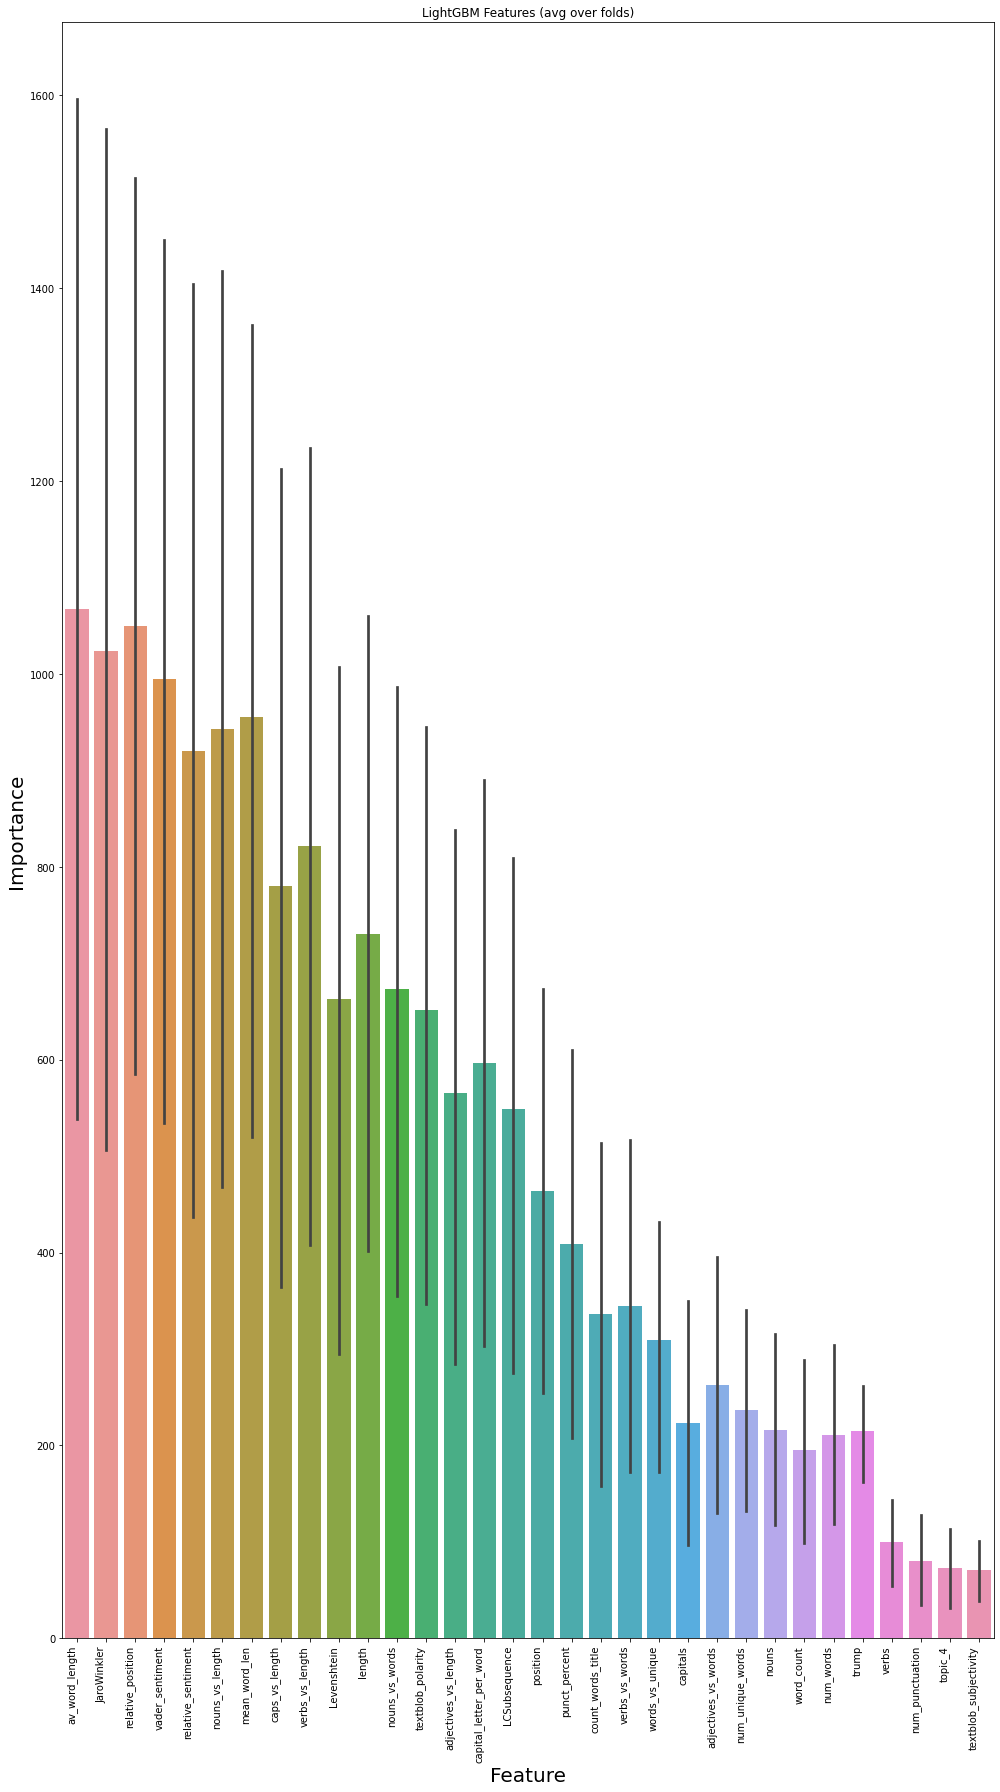

In [ ]:
plt = feature_importance_graph(report)


In [ ]:
# On additional data funlines
train = pd.concat([train_h,train_f])
test = test_h
target = train['meanGrade']
predictions, predictions_train, feature_importance_df = light_gbm(train, target, test, features)


fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.558957	valid_1's rmse: 0.567439
[200]	training's rmse: 0.545466	valid_1's rmse: 0.561078
[300]	training's rmse: 0.536361	valid_1's rmse: 0.559703
[400]	training's rmse: 0.528468	valid_1's rmse: 0.559353
[500]	training's rmse: 0.521162	valid_1's rmse: 0.559238
[600]	training's rmse: 0.514097	valid_1's rmse: 0.559198
Early stopping, best iteration is:
[450]	training's rmse: 0.524709	valid_1's rmse: 0.559114
fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.558127	valid_1's rmse: 0.571827
[200]	training's rmse: 0.54446	valid_1's rmse: 0.565985
[300]	training's rmse: 0.535419	valid_1's rmse: 0.56442
[400]	training's rmse: 0.527498	valid_1's rmse: 0.563939
[500]	training's rmse: 0.520143	valid_1's rmse: 0.563615
[600]	training's rmse: 0.513405	valid_1's rmse: 0.563357
[700]	training's rmse: 0.507007	valid_1's rmse: 0.563295
[800]	training's rmse: 0.5008

In [ ]:
## Final Results: Trained on Train+Dev. Tested on Competition Test Set

In [ ]:
# Now on Entire training and Dev, and the competitions Test!
train = pd.concat([train_h,dev_h])
test = test_h
target = train['meanGrade']

In [ ]:
predictions, predictions_train, feature_importance_df = light_gbm(train, target, test, features)


fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.560571	valid_1's rmse: 0.575691
[200]	training's rmse: 0.546447	valid_1's rmse: 0.574229
[300]	training's rmse: 0.534505	valid_1's rmse: 0.574008
[400]	training's rmse: 0.523884	valid_1's rmse: 0.573641
[500]	training's rmse: 0.514187	valid_1's rmse: 0.573369
[600]	training's rmse: 0.505019	valid_1's rmse: 0.573512
[700]	training's rmse: 0.496351	valid_1's rmse: 0.573959
Early stopping, best iteration is:
[500]	training's rmse: 0.514187	valid_1's rmse: 0.573369
fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.561358	valid_1's rmse: 0.573578
[200]	training's rmse: 0.547383	valid_1's rmse: 0.570853
[300]	training's rmse: 0.535423	valid_1's rmse: 0.569639
[400]	training's rmse: 0.524894	valid_1's rmse: 0.568688
[500]	training's rmse: 0.515125	valid_1's rmse: 0.568052
[600]	training's rmse: 0.505971	valid_1's rmse: 0.567337
[700]	training's rmse: 0.49

In [ ]:
print('Gradient Boosting Hand Crafted Test Set performance')
print(model_performance(predictions,test['meanGrade'],True))


Gradient Boosting Hand Crafted Test Set performance
| MSE: 0.3248 | RMSE: 0.5699 |
(982.2708246415002, 0.32482500814864446)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd0ae3bf-8b9c-46ca-9eb4-5ef4b3522174' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>